## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'syntheticMRI2D-sagittal' 
TRANSFORM = 'wavelet-vertical'
CHANNEL = ''

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
vertical_wavelet_sagittal_syntheticMRI2D.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/syntheticMRI2D/sagittal/wavelet/vertical'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 0,
 3: 3396,
 4: 98808,
 5: 524004,
 6: 2418270,
 7: 10234344,
 8: 42110360,
 9: 170911996}

Running 12760 CDFs


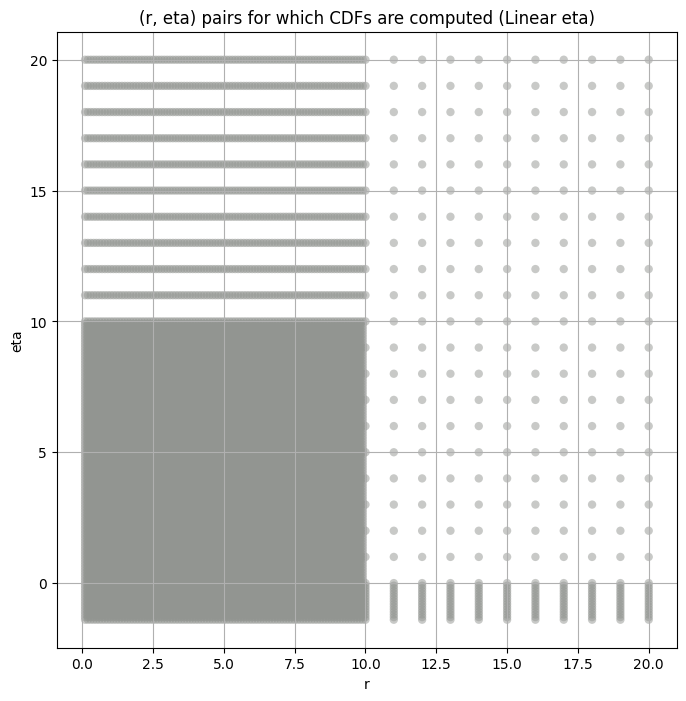

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.1, -1.4), <scipy.interpolate._fitpack2.Int...",0.1,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.628800e+06,554265.000000
1,"((0.1, -1.3), <scipy.interpolate._fitpack2.Int...",0.1,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.991680e+07,96192.272727
2,"((0.1, -1.2), <scipy.interpolate._fitpack2.Int...",0.1,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,2.395008e+08,29390.000000
3,"((0.1, -1.1), <scipy.interpolate._fitpack2.Int...",0.1,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.037837e+09,11997.692308
4,"((0.1, -1.0), <scipy.interpolate._fitpack2.Int...",0.1,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.632429e+09,5874.890110


In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


100%|██████████| 100000/100000 [00:31<00:00, 3149.53it/s]


Layer 3


100%|██████████| 100000/100000 [01:25<00:00, 1171.36it/s]


Layer 4


100%|██████████| 100000/100000 [01:17<00:00, 1294.78it/s]


Layer 5


100%|██████████| 100000/100000 [01:20<00:00, 1246.90it/s]


Layer 6


100%|██████████| 100000/100000 [01:15<00:00, 1331.83it/s]


Layer 7


100%|██████████| 100000/100000 [01:12<00:00, 1377.66it/s]


Layer 8


100%|██████████| 100000/100000 [01:11<00:00, 1390.11it/s]


Layer 9


100%|██████████| 100000/100000 [01:11<00:00, 1398.92it/s]


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
layer,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,170242.3400,158532.73000,182420.11000,0.515903,0.211426,0.856390,3396.0
4,211857.3600,203747.67000,220165.00000,0.256788,0.035012,0.512372,98808.0
5,72605.1400,68413.51000,76957.79000,3.195013,2.597310,3.898776,524004.0
6,29841.0370,27415.11100,32359.33800,8.380878,7.359658,9.473640,2418270.0
7,8457.4630,7687.83840,9267.63400,11.092089,9.864655,12.411221,10234344.0
8,1116.0948,1005.35650,1233.48550,13.691368,11.792415,16.311457,42110360.0
9,107.6861,94.23181,123.26981,24.950508,16.698538,47.740410,170911996.0


## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500
layer,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,170242.3400,170242.343750,149111.234375,136283.468750,126321.632812,117783.585938,103710.906250,92142.578125,82288.390625,73648.273438,66030.187500,47623.574219
4,211857.3600,211857.359375,209810.093750,208288.968750,206939.218750,205668.187500,203370.265625,201311.734375,199399.578125,197640.890625,196008.406250,191665.562500
5,72605.1400,72605.140625,71412.890625,70511.515625,69701.734375,68957.078125,67619.093750,66432.195312,65359.753906,64373.316406,63455.781250,61017.160156
6,29841.0370,29841.037109,29170.556641,28624.986328,28130.919922,27672.123047,26826.560547,26054.537109,25341.761719,24677.865234,24055.000000,22386.859375
7,8457.4630,8457.462891,8247.355469,8068.560059,7906.705566,7757.071777,7483.410156,7235.280762,7006.152832,6792.164062,6591.045898,6050.552734
8,1116.0948,1116.094849,1081.320068,1052.726196,1026.805542,1002.902588,959.819946,921.718384,887.502869,856.475464,828.045410,754.680908
9,107.6861,107.686096,100.900520,96.751175,93.291367,90.269135,85.181091,81.019966,77.509979,74.470520,71.782570,65.160339


####
Layer  2
####
Layer  3


100%|██████████| 12760/12760 [00:03<00:00, 3455.75it/s]


Finding Minimum after computing 12760 CDFs
3 0 0.005922218919923172 170242.34


100%|██████████| 12760/12760 [00:03<00:00, 3602.73it/s]


Finding Minimum after computing 12760 CDFs
3 25 0.011821937468830965 149111.23


100%|██████████| 12760/12760 [00:03<00:00, 3863.58it/s]


Finding Minimum after computing 12760 CDFs
3 50 0.020951935368068497 136283.47


100%|██████████| 12760/12760 [00:02<00:00, 4283.91it/s]


Finding Minimum after computing 12760 CDFs
3 75 0.029110951447318373 126321.63


100%|██████████| 12760/12760 [00:03<00:00, 4137.11it/s]


Finding Minimum after computing 12760 CDFs
3 100 0.03658913552834775 117783.586


100%|██████████| 12760/12760 [00:03<00:00, 4154.65it/s]


Finding Minimum after computing 12760 CDFs
3 150 0.05045332813616457 103710.91


100%|██████████| 12760/12760 [00:04<00:00, 3171.33it/s]


Finding Minimum after computing 12760 CDFs
3 200 0.06407695120114637 92142.58


100%|██████████| 12760/12760 [00:03<00:00, 3572.33it/s]


Finding Minimum after computing 12760 CDFs
3 250 0.07759023073699278 82288.39


100%|██████████| 12760/12760 [00:03<00:00, 3952.36it/s]


Finding Minimum after computing 12760 CDFs
3 300 0.09062243096696826 73648.27


100%|██████████| 12760/12760 [00:03<00:00, 3834.49it/s]


Finding Minimum after computing 12760 CDFs
3 350 0.10313570018866222 66030.19


100%|██████████| 12760/12760 [00:03<00:00, 3679.84it/s]


Finding Minimum after computing 12760 CDFs
3 500 0.13780015702919818 47623.574
Number of samples: 3396, Without approximation : 3396.0


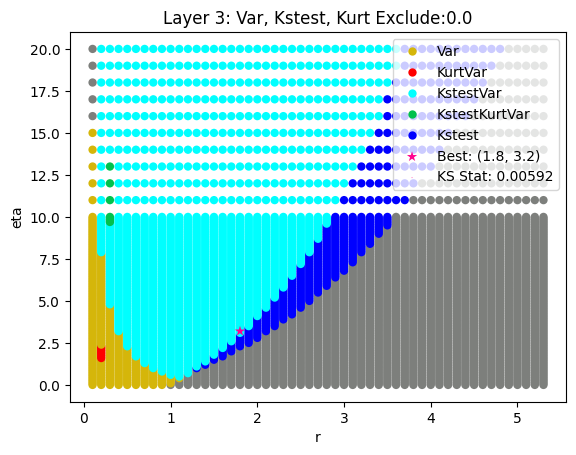

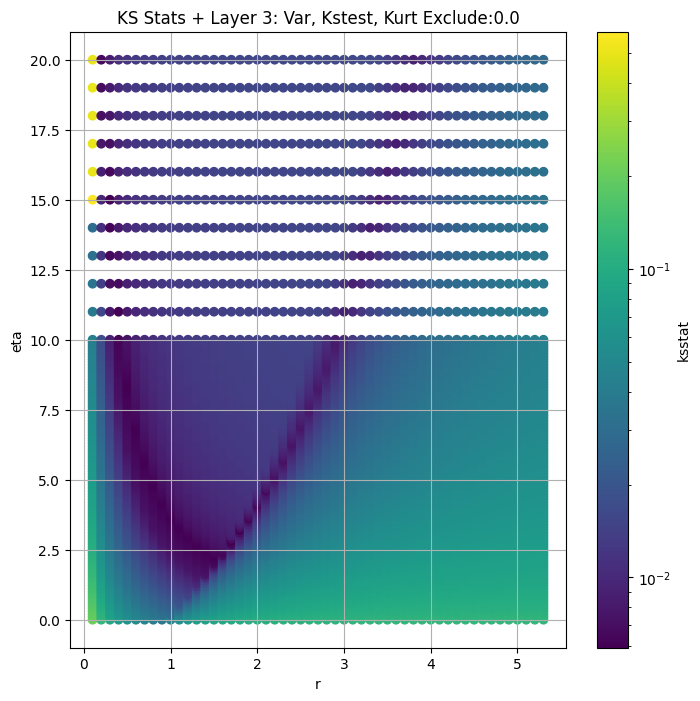

####
Layer  4


100%|██████████| 12760/12760 [03:42<00:00, 57.22it/s] 


Finding Minimum after computing 12760 CDFs
4 0 0.007033291195468305 211857.36


100%|██████████| 12760/12760 [04:54<00:00, 43.34it/s] 


Finding Minimum after computing 12760 CDFs
4 25 0.006619638075362699 209810.1


100%|██████████| 12760/12760 [03:30<00:00, 60.52it/s] 


Finding Minimum after computing 12760 CDFs
4 50 0.00733397793301227 208288.97


100%|██████████| 12760/12760 [04:24<00:00, 48.31it/s] 


Finding Minimum after computing 12760 CDFs
4 75 0.00811285827483707 206939.22


100%|██████████| 12760/12760 [00:46<00:00, 272.84it/s]


Finding Minimum after computing 12760 CDFs
4 100 0.008850614930807604 205668.19


100%|██████████| 12760/12760 [00:44<00:00, 288.27it/s]


Finding Minimum after computing 12760 CDFs
4 150 0.010162480884261804 203370.27


100%|██████████| 12760/12760 [00:46<00:00, 274.53it/s]


Finding Minimum after computing 12760 CDFs
4 200 0.011378992172209001 201311.73


100%|██████████| 12760/12760 [00:44<00:00, 289.32it/s]


Finding Minimum after computing 12760 CDFs
4 250 0.012519163132855171 199399.58


100%|██████████| 12760/12760 [00:45<00:00, 278.39it/s]


Finding Minimum after computing 12760 CDFs
4 300 0.013576568883219564 197640.89


100%|██████████| 12760/12760 [00:42<00:00, 301.98it/s]


Finding Minimum after computing 12760 CDFs
4 350 0.01453865271315491 196008.4


100%|██████████| 12760/12760 [00:42<00:00, 302.11it/s]


Finding Minimum after computing 12760 CDFs
4 500 0.0172165275339686 191665.56
Number of samples: 98808, Without approximation : 98808.0


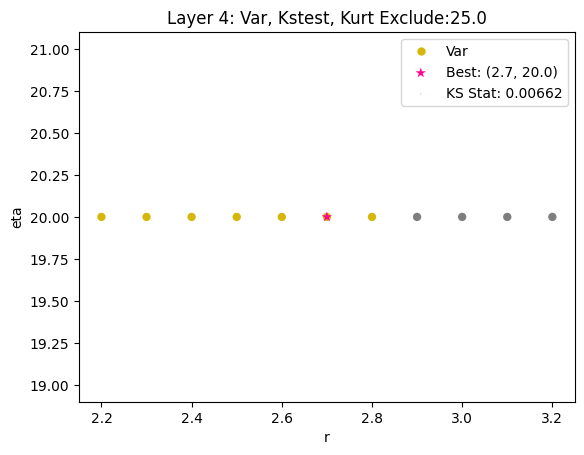

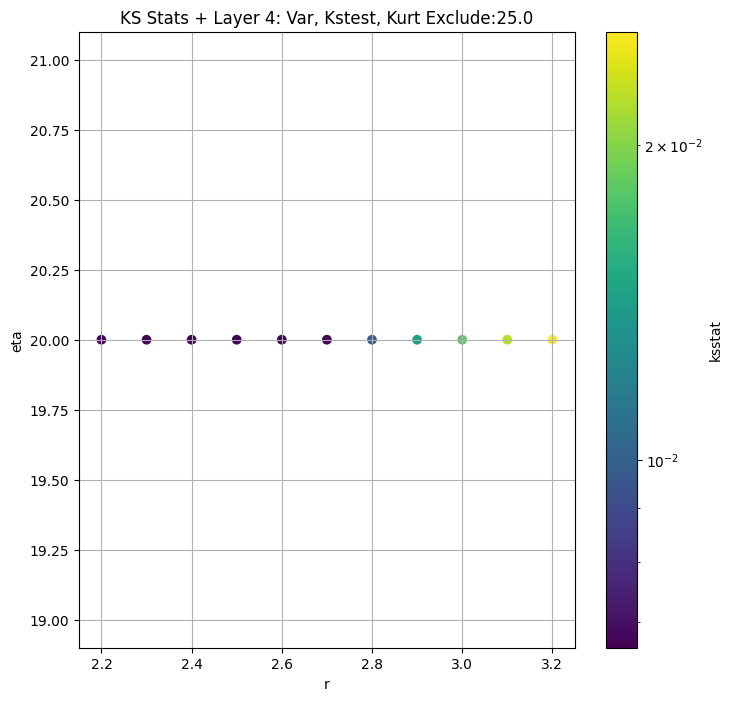

####
Layer  5


100%|██████████| 12760/12760 [00:42<00:00, 301.96it/s]


Finding Minimum after computing 12760 CDFs
5 0 0.004531229703257894 72605.14


100%|██████████| 12760/12760 [00:42<00:00, 298.56it/s]


Finding Minimum after computing 12760 CDFs
5 25 0.00477222551834211 71412.89


100%|██████████| 12760/12760 [00:42<00:00, 301.60it/s]


Finding Minimum after computing 12760 CDFs
5 50 0.004729952073438737 70511.516


100%|██████████| 12760/12760 [00:42<00:00, 303.04it/s]


Finding Minimum after computing 12760 CDFs
5 75 0.005295976686976567 69701.734


100%|██████████| 12760/12760 [00:42<00:00, 301.54it/s]


Finding Minimum after computing 12760 CDFs
5 100 0.005354426292994874 68957.08


100%|██████████| 12760/12760 [00:43<00:00, 295.32it/s]


Finding Minimum after computing 12760 CDFs
5 150 0.006011927317834287 67619.09


100%|██████████| 12760/12760 [00:43<00:00, 293.03it/s]


Finding Minimum after computing 12760 CDFs
5 200 0.006781832116267927 66432.195


100%|██████████| 12760/12760 [00:42<00:00, 299.95it/s]


Finding Minimum after computing 12760 CDFs
5 250 0.007715802402506022 65359.754


100%|██████████| 12760/12760 [00:42<00:00, 300.25it/s]


Finding Minimum after computing 12760 CDFs
5 300 0.008582309218371338 64373.316


100%|██████████| 12760/12760 [00:42<00:00, 299.84it/s]


Finding Minimum after computing 12760 CDFs
5 350 0.009218321576333711 63455.78


100%|██████████| 12760/12760 [00:42<00:00, 302.06it/s]


Finding Minimum after computing 12760 CDFs
5 500 0.011318769085583935 61017.16
Number of samples: 100000, Without approximation : 524004.0


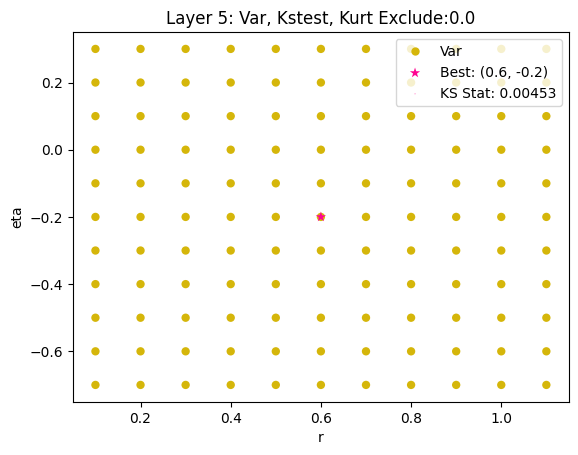

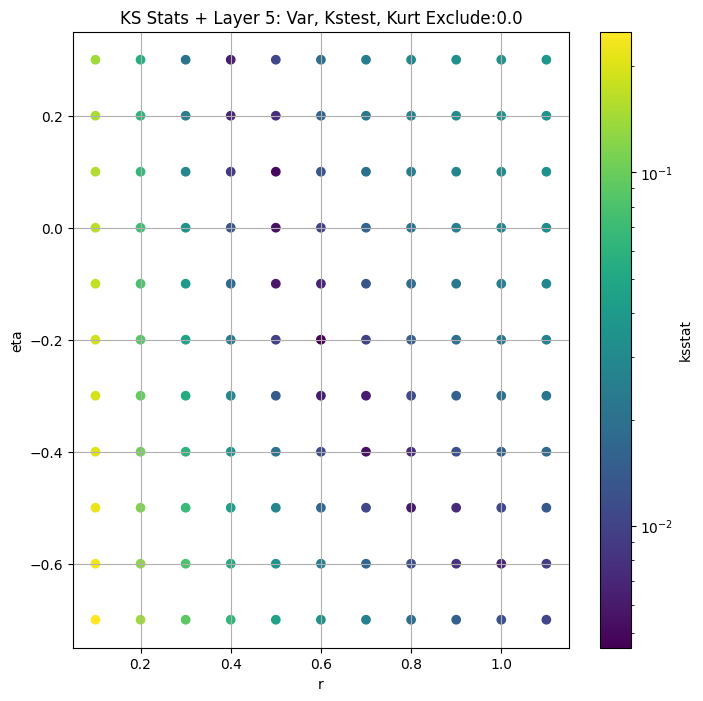

####
Layer  6


100%|██████████| 12760/12760 [00:42<00:00, 301.91it/s]


Finding Minimum after computing 12760 CDFs
6 0 0.0028612018318384114 29841.037


100%|██████████| 12760/12760 [00:42<00:00, 296.76it/s]


Finding Minimum after computing 12760 CDFs
6 25 0.0034024564277897254 29170.557


100%|██████████| 12760/12760 [00:42<00:00, 301.88it/s]


Finding Minimum after computing 12760 CDFs
6 50 0.003768360987854602 28624.986


100%|██████████| 12760/12760 [00:42<00:00, 299.56it/s]


Finding Minimum after computing 12760 CDFs
6 75 0.0035365777288495215 28130.92


100%|██████████| 12760/12760 [00:42<00:00, 301.62it/s]


Finding Minimum after computing 12760 CDFs
6 100 0.004141935590269208 27672.123


100%|██████████| 12760/12760 [00:42<00:00, 301.97it/s]


Finding Minimum after computing 12760 CDFs
6 150 0.004087153388432463 26826.56


100%|██████████| 12760/12760 [00:42<00:00, 302.05it/s]


Finding Minimum after computing 12760 CDFs
6 200 0.005113892015690548 26054.537


100%|██████████| 12760/12760 [00:42<00:00, 301.94it/s]


Finding Minimum after computing 12760 CDFs
6 250 0.005718643696755593 25341.762


100%|██████████| 12760/12760 [00:43<00:00, 296.19it/s]


Finding Minimum after computing 12760 CDFs
6 300 0.005590663430831311 24677.865


100%|██████████| 12760/12760 [00:43<00:00, 293.91it/s]


Finding Minimum after computing 12760 CDFs
6 350 0.005881677707866073 24055.0


100%|██████████| 12760/12760 [00:43<00:00, 291.69it/s]


Finding Minimum after computing 12760 CDFs
6 500 0.007970838589647089 22386.86
Number of samples: 100000, Without approximation : 2418270.0


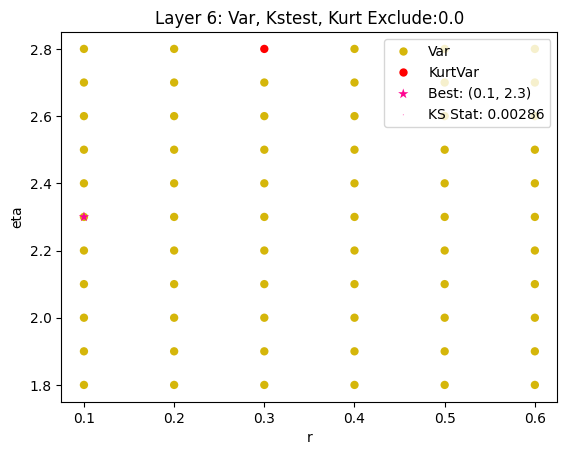

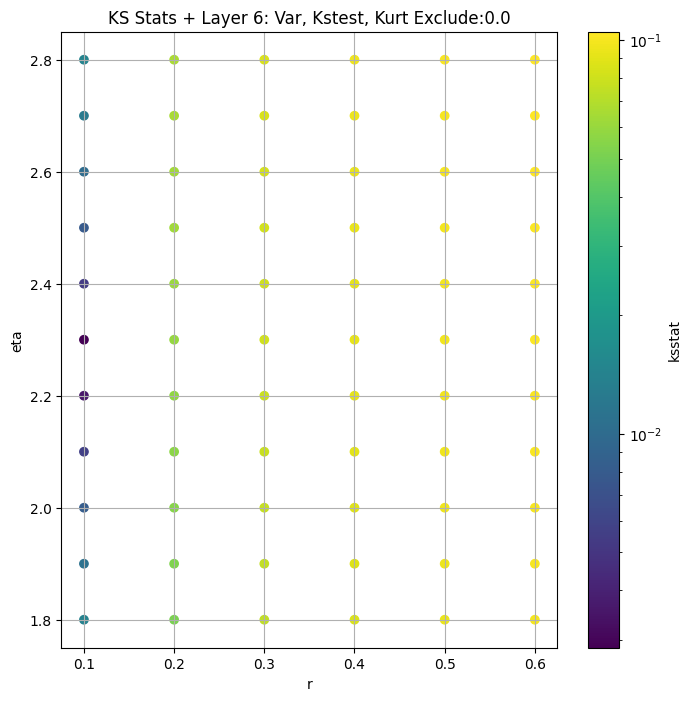

####
Layer  7


100%|██████████| 12760/12760 [00:42<00:00, 297.95it/s]


Finding Minimum after computing 12760 CDFs
7 0 0.00545037231336315 8457.463


100%|██████████| 12760/12760 [00:42<00:00, 302.83it/s]


Finding Minimum after computing 12760 CDFs
7 25 0.004109366823340843 8247.355


100%|██████████| 12760/12760 [00:42<00:00, 298.86it/s]


Finding Minimum after computing 12760 CDFs
7 50 0.004809426102018177 8068.56


100%|██████████| 12760/12760 [00:43<00:00, 296.11it/s]


Finding Minimum after computing 12760 CDFs
7 75 0.004657906956706759 7906.7056


100%|██████████| 12760/12760 [00:43<00:00, 296.73it/s]


Finding Minimum after computing 12760 CDFs
7 100 0.0049276510938791596 7757.072


100%|██████████| 12760/12760 [00:42<00:00, 297.75it/s]


Finding Minimum after computing 12760 CDFs
7 150 0.005414907928673163 7483.41


100%|██████████| 12760/12760 [00:43<00:00, 296.14it/s]


Finding Minimum after computing 12760 CDFs
7 200 0.00549217479445519 7235.281


100%|██████████| 12760/12760 [00:42<00:00, 300.07it/s]


Finding Minimum after computing 12760 CDFs
7 250 0.006358445022783876 7006.153


100%|██████████| 12760/12760 [00:42<00:00, 302.13it/s]


Finding Minimum after computing 12760 CDFs
7 300 0.006499070719765743 6792.164


100%|██████████| 12760/12760 [00:42<00:00, 303.06it/s]


Finding Minimum after computing 12760 CDFs
7 350 0.007200985662907611 6591.046


100%|██████████| 12760/12760 [00:42<00:00, 302.12it/s]


Finding Minimum after computing 12760 CDFs
7 500 0.008425461542807655 6050.5527
Number of samples: 100000, Without approximation : 10234344.0


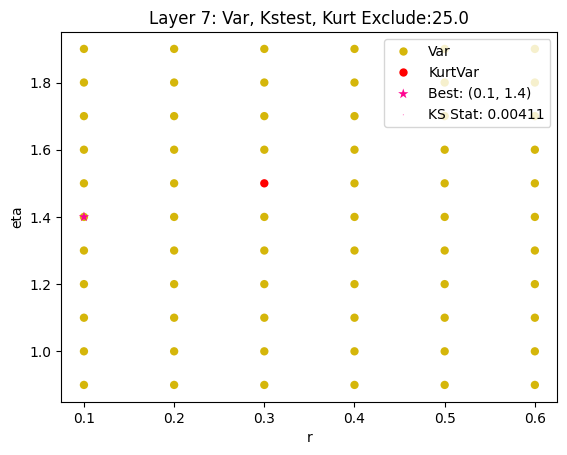

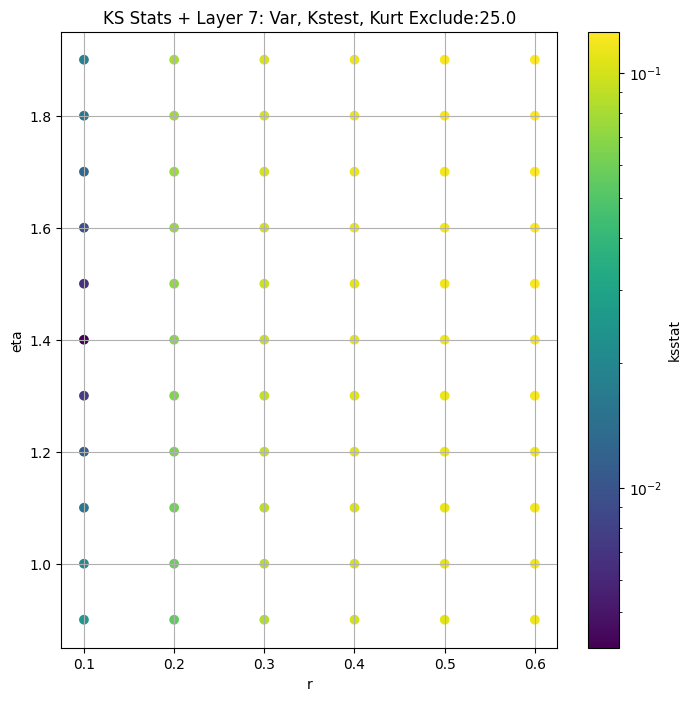

####
Layer  8


100%|██████████| 12760/12760 [00:42<00:00, 303.44it/s]


Finding Minimum after computing 12760 CDFs
8 0 0.004195546070131451 1116.0948


100%|██████████| 12760/12760 [00:42<00:00, 303.40it/s]


Finding Minimum after computing 12760 CDFs
8 25 0.003393522959987294 1081.3201


100%|██████████| 12760/12760 [00:42<00:00, 303.39it/s]


Finding Minimum after computing 12760 CDFs
8 50 0.003539935352346757 1052.7262


100%|██████████| 12760/12760 [00:42<00:00, 302.96it/s]


Finding Minimum after computing 12760 CDFs
8 75 0.0036201086500638434 1026.8055


100%|██████████| 12760/12760 [00:42<00:00, 303.66it/s]


Finding Minimum after computing 12760 CDFs
8 100 0.003911708122628421 1002.9026


100%|██████████| 12760/12760 [00:42<00:00, 303.32it/s]


Finding Minimum after computing 12760 CDFs
8 150 0.004631580628259024 959.81995


100%|██████████| 12760/12760 [00:42<00:00, 303.04it/s]


Finding Minimum after computing 12760 CDFs
8 200 0.0048844911271425095 921.7184


100%|██████████| 12760/12760 [00:42<00:00, 303.46it/s]


Finding Minimum after computing 12760 CDFs
8 250 0.005320800377217272 887.50287


100%|██████████| 12760/12760 [00:42<00:00, 302.53it/s]


Finding Minimum after computing 12760 CDFs
8 300 0.006110951065327552 856.47546


100%|██████████| 12760/12760 [00:42<00:00, 303.36it/s]


Finding Minimum after computing 12760 CDFs
8 350 0.006192452299805029 828.0454


100%|██████████| 12760/12760 [00:42<00:00, 302.74it/s]


Finding Minimum after computing 12760 CDFs
8 500 0.007864844418925931 754.6809
Number of samples: 100000, Without approximation : 42110360.0


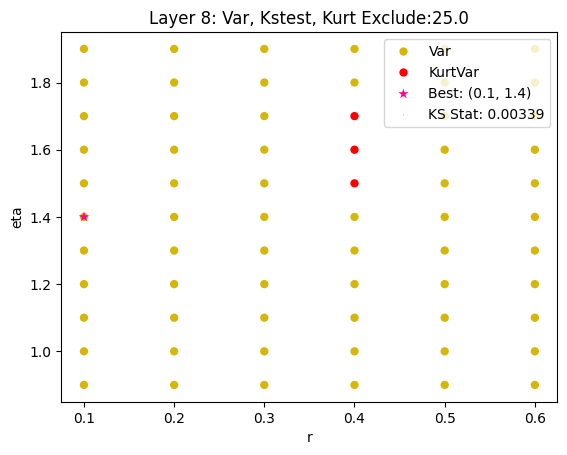

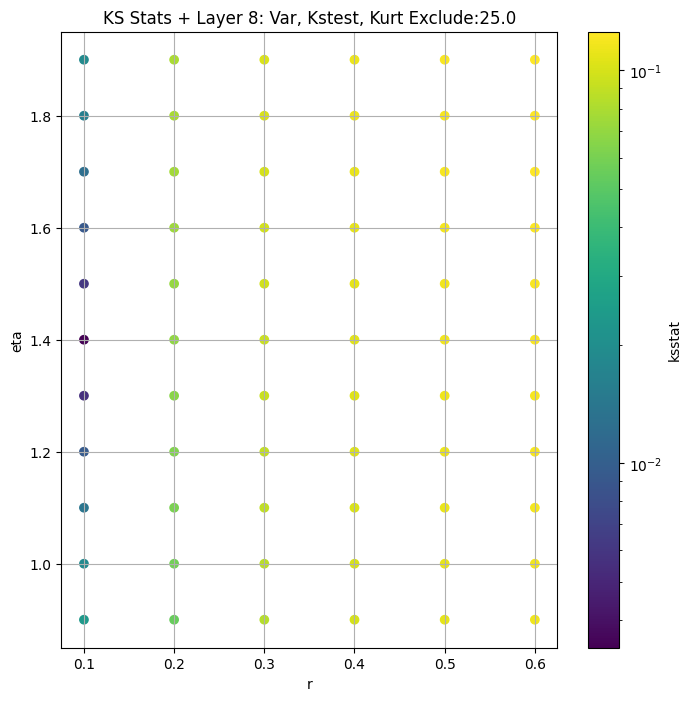

####
Layer  9


100%|██████████| 12760/12760 [00:42<00:00, 300.42it/s]


Finding Minimum after computing 12760 CDFs
9 0 0.005294382990217006 107.6861


100%|██████████| 12760/12760 [00:42<00:00, 301.91it/s]


Finding Minimum after computing 12760 CDFs
9 25 0.00453750489958038 100.90052


100%|██████████| 12760/12760 [00:42<00:00, 303.09it/s]


Finding Minimum after computing 12760 CDFs
9 50 0.003950058130073958 96.751175


100%|██████████| 12760/12760 [00:42<00:00, 302.89it/s]


Finding Minimum after computing 12760 CDFs
9 75 0.004502460289824595 93.29137


100%|██████████| 12760/12760 [00:41<00:00, 303.82it/s]


Finding Minimum after computing 12760 CDFs
9 100 0.0037094066936098034 90.269135


100%|██████████| 12760/12760 [00:42<00:00, 300.69it/s]


Finding Minimum after computing 12760 CDFs
9 150 0.004613493163162619 85.18109


100%|██████████| 12760/12760 [00:42<00:00, 302.69it/s]


Finding Minimum after computing 12760 CDFs
9 200 0.004862146170420578 81.019966


100%|██████████| 12760/12760 [00:42<00:00, 300.23it/s]


Finding Minimum after computing 12760 CDFs
9 250 0.005626816198707162 77.50998


100%|██████████| 12760/12760 [00:42<00:00, 303.04it/s]


Finding Minimum after computing 12760 CDFs
9 300 0.006365926871804151 74.47052


100%|██████████| 12760/12760 [00:42<00:00, 301.50it/s]


Finding Minimum after computing 12760 CDFs
9 350 0.0070798833930350025 71.78257


100%|██████████| 12760/12760 [00:42<00:00, 303.55it/s]


Finding Minimum after computing 12760 CDFs
9 500 0.008032146363894377 65.16034
Number of samples: 100000, Without approximation : 170911996.0


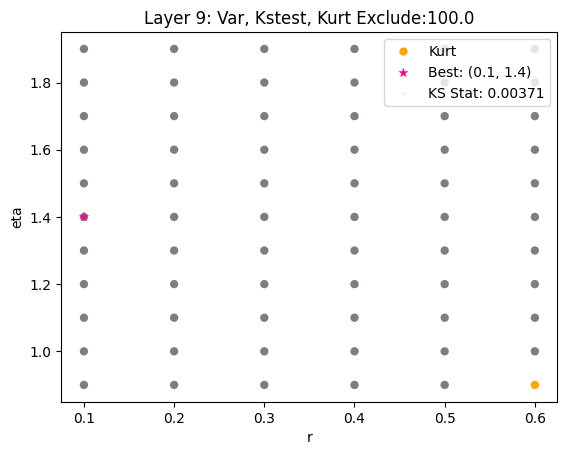

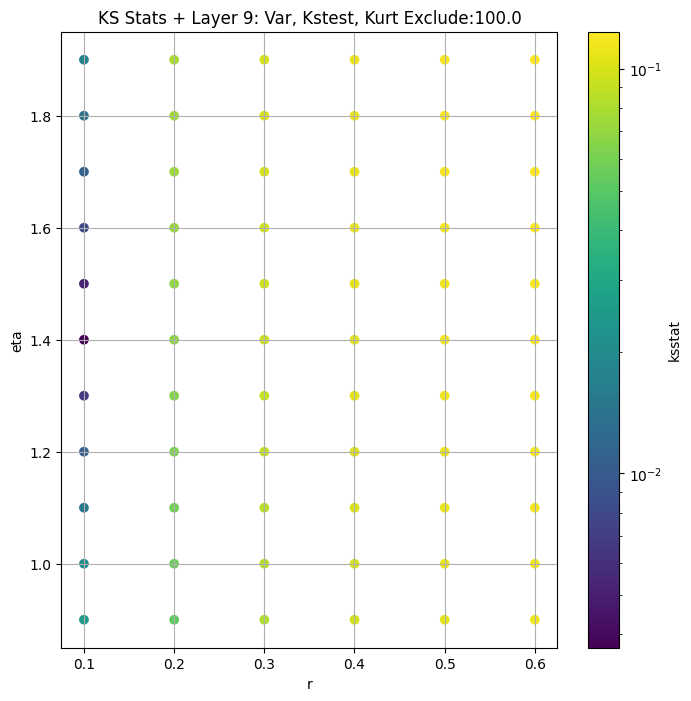

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05
layer,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,170242.3400,158532.73000,182420.11000,0.515903,0.211426,0.856390,3396.0,0.005922,1.8,3.2,1.000000e+05,0.0,170242.340000,0.023255
4,211857.3600,203747.67000,220165.00000,0.256788,0.035012,0.512372,98808.0,0.006620,2.7,20.0,9.873809e+04,25.0,209810.100000,0.004319
5,72605.1400,68413.51000,76957.79000,3.195013,2.597310,3.898776,524004.0,0.004531,0.6,-0.2,1.608277e+04,0.0,72605.140000,0.001876
6,29841.0370,27415.11100,32359.33800,8.380878,7.359658,9.473640,2418270.0,0.002861,0.1,2.3,1.588120e-12,0.0,29841.037000,0.000873
7,8457.4630,7687.83840,9267.63400,11.092089,9.864655,12.411221,10234344.0,0.004109,0.1,1.4,4.807675e-12,25.0,8247.355000,0.000425
8,1116.0948,1005.35650,1233.48550,13.691368,11.792415,16.311457,42110360.0,0.003394,0.1,1.4,6.303396e-13,25.0,1081.320100,0.000209
9,107.6861,94.23181,123.26981,24.950508,16.698538,47.740410,170911996.0,0.003709,0.1,1.4,5.262106e-14,100.0,90.269135,0.000104


In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2
Layer 3


100%|██████████| 657/657 [00:00<00:00, 2813.81it/s]


Finding Minimum after computing 657 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.04004819254489153, var: 117783.5859375


100%|██████████| 657/657 [00:00<00:00, 7052.03it/s]


Finding Minimum after computing 657 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.031815427258479134, var: 126321.6328125


100%|██████████| 657/657 [00:00<00:00, 7049.65it/s]


Finding Minimum after computing 657 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.02359593367241354, var: 136283.46875


100%|██████████| 657/657 [00:00<00:00, 7068.25it/s]


Finding Minimum after computing 657 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.014208463082640177, var: 149111.234375


100%|██████████| 657/657 [00:00<00:00, 7012.21it/s]


Finding Minimum after computing 657 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.005922218919923172, var: 170242.34375
Number of samples: 3396, Without approximation : 3396.0


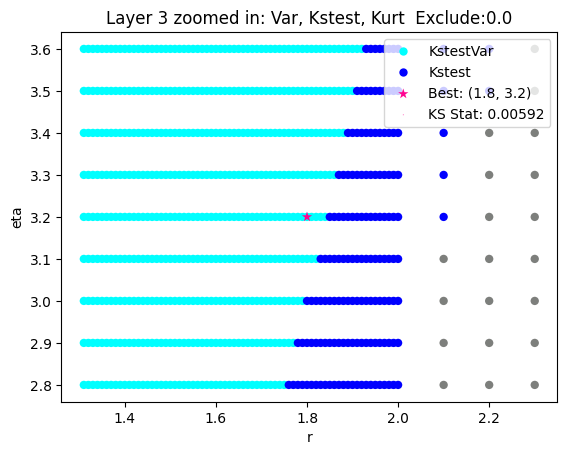

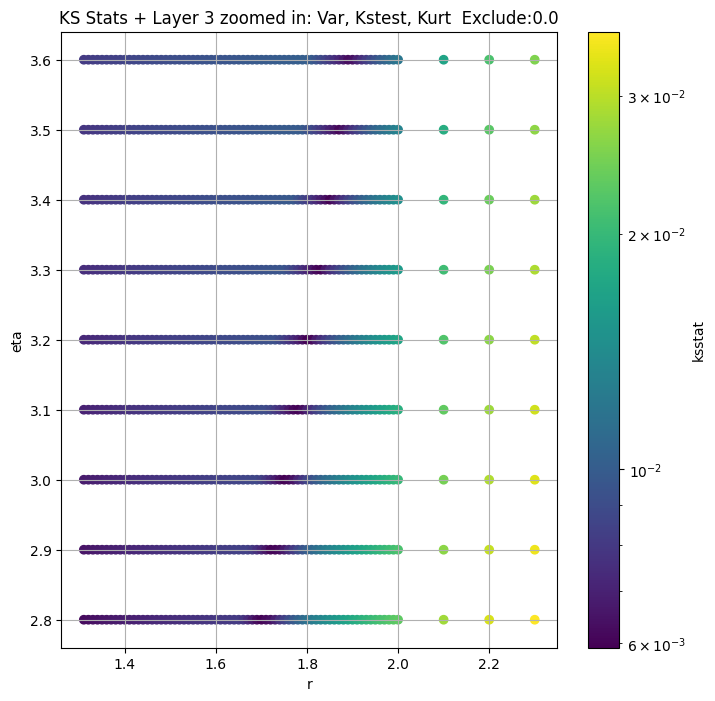

Layer 4


100%|██████████| 9/9 [00:00<00:00, 281.09it/s]


Finding Minimum after computing 9 CDFs
layer 4, 25.0 + 100 = 125, ksstat: 0.009541940492242912, var: 204483.671875


100%|██████████| 9/9 [00:00<00:00, 250.84it/s]


Finding Minimum after computing 9 CDFs
layer 4, 25.0 + 75 = 100, ksstat: 0.008850614930807604, var: 205668.1875


100%|██████████| 9/9 [00:00<00:00, 288.02it/s]


Finding Minimum after computing 9 CDFs
layer 4, 25.0 + 50 = 75, ksstat: 0.00811285827483707, var: 206939.21875


100%|██████████| 9/9 [00:00<00:00, 294.53it/s]


Finding Minimum after computing 9 CDFs
layer 4, 25.0 + 25 = 50, ksstat: 0.00733397793301227, var: 208288.96875


100%|██████████| 9/9 [00:00<00:00, 278.43it/s]


Finding Minimum after computing 9 CDFs
layer 4, 25.0 + 0 = 25, ksstat: 0.006619638075362699, var: 209810.09375


100%|██████████| 9/9 [00:00<00:00, 298.78it/s]


Finding Minimum after computing 9 CDFs
layer 4, 25.0 + -25 = 0, ksstat: 0.007265797366941329, var: 211857.359375
Number of samples: 98808, Without approximation : 98808.0


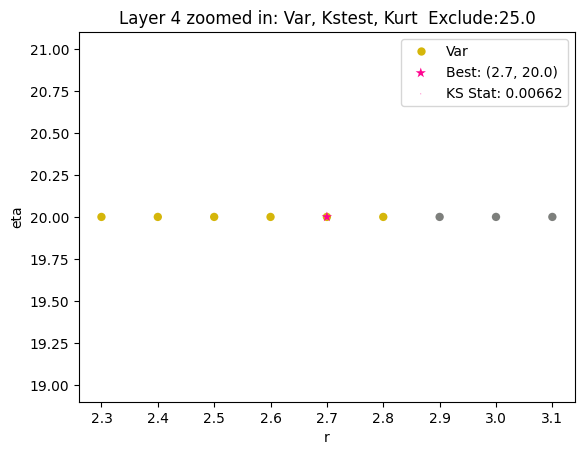

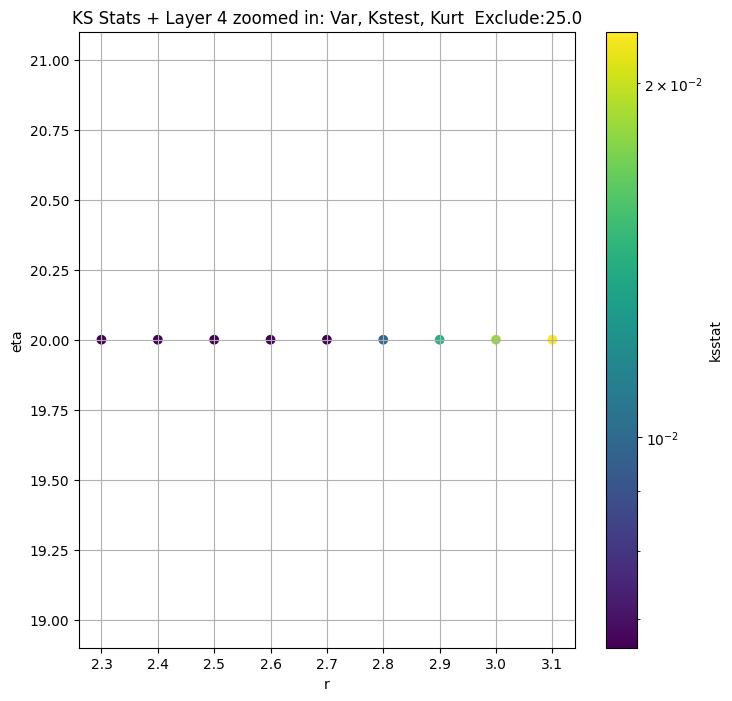

Layer 5


100%|██████████| 1557/1557 [00:05<00:00, 279.92it/s]


Finding Minimum after computing 1557 CDFs
layer 5, 0.0 + 100 = 100, ksstat: 0.0054732444571996205, var: 68957.078125


100%|██████████| 1557/1557 [00:05<00:00, 301.20it/s]


Finding Minimum after computing 1557 CDFs
layer 5, 0.0 + 75 = 75, ksstat: 0.004913040129872592, var: 69701.734375


100%|██████████| 1557/1557 [00:05<00:00, 284.88it/s]


Finding Minimum after computing 1557 CDFs
layer 5, 0.0 + 50 = 50, ksstat: 0.004664992871866461, var: 70511.515625


100%|██████████| 1557/1557 [00:05<00:00, 303.84it/s]


Finding Minimum after computing 1557 CDFs
layer 5, 0.0 + 25 = 25, ksstat: 0.004388012009028608, var: 71412.890625


100%|██████████| 1557/1557 [00:05<00:00, 304.01it/s]


Finding Minimum after computing 1557 CDFs
layer 5, 0.0 + 0 = 0, ksstat: 0.004014731097828322, var: 72605.140625
Number of samples: 100000, Without approximation : 524004.0


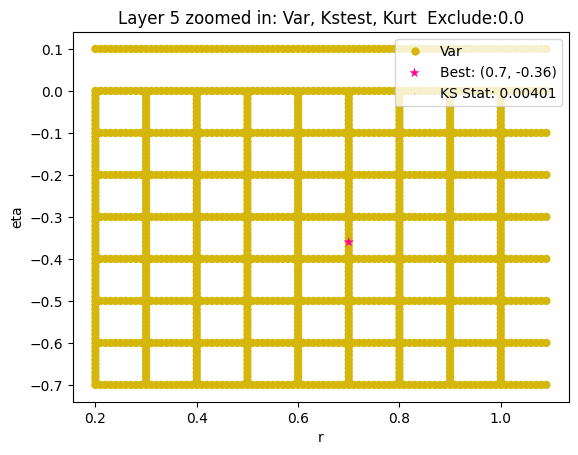

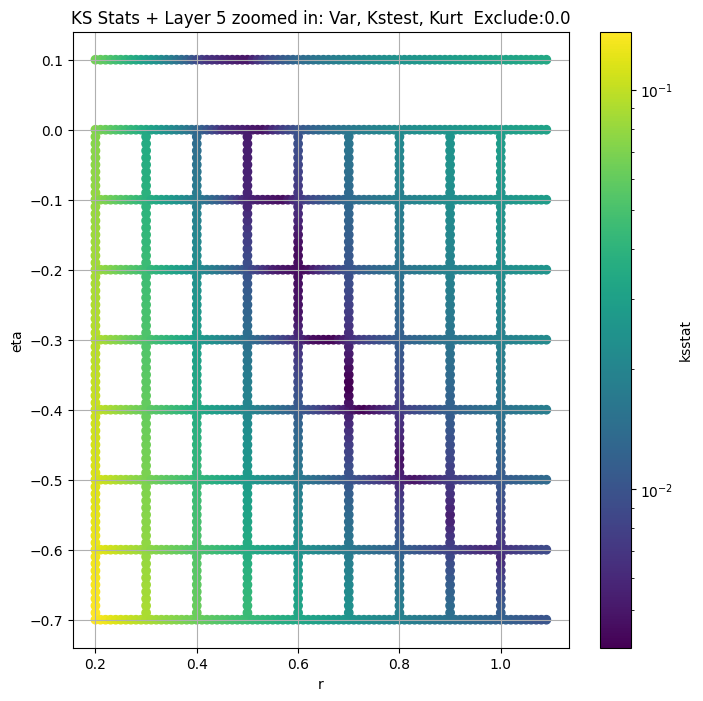

Layer 6


100%|██████████| 580/580 [00:02<00:00, 277.42it/s]


Finding Minimum after computing 580 CDFs
layer 6, 0.0 + 100 = 100, ksstat: 0.004297640251846535, var: 27672.123046875


100%|██████████| 580/580 [00:01<00:00, 304.02it/s]


Finding Minimum after computing 580 CDFs
layer 6, 0.0 + 75 = 75, ksstat: 0.0037438673239565956, var: 28130.919921875


100%|██████████| 580/580 [00:01<00:00, 302.37it/s]


Finding Minimum after computing 580 CDFs
layer 6, 0.0 + 50 = 50, ksstat: 0.0036932431651578446, var: 28624.986328125


100%|██████████| 580/580 [00:01<00:00, 303.05it/s]


Finding Minimum after computing 580 CDFs
layer 6, 0.0 + 25 = 25, ksstat: 0.002980363813640311, var: 29170.556640625


100%|██████████| 580/580 [00:01<00:00, 304.09it/s]


Finding Minimum after computing 580 CDFs
layer 6, 0.0 + 0 = 0, ksstat: 0.00269952576919652, var: 29841.037109375
Number of samples: 100000, Without approximation : 2418270.0


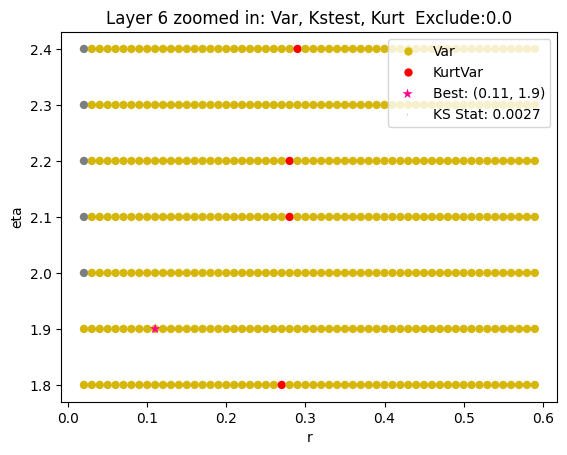

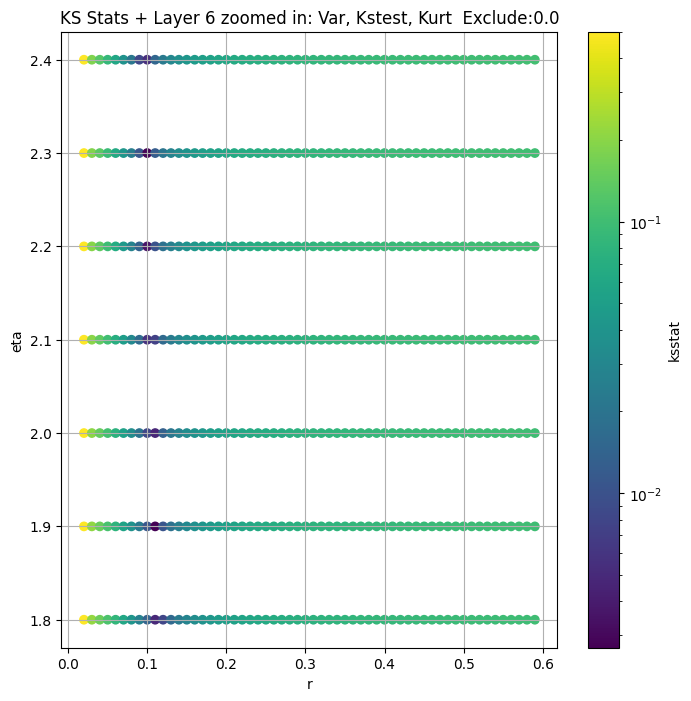

Layer 7


100%|██████████| 580/580 [00:02<00:00, 281.34it/s]


Finding Minimum after computing 580 CDFs
layer 7, 25.0 + 100 = 125, ksstat: 0.005076007424174614, var: 7616.5400390625


100%|██████████| 580/580 [00:01<00:00, 303.60it/s]


Finding Minimum after computing 580 CDFs
layer 7, 25.0 + 75 = 100, ksstat: 0.004818446494842279, var: 7757.07177734375


100%|██████████| 580/580 [00:01<00:00, 302.60it/s]


Finding Minimum after computing 580 CDFs
layer 7, 25.0 + 50 = 75, ksstat: 0.004609256545232809, var: 7906.70556640625


100%|██████████| 580/580 [00:01<00:00, 300.27it/s]


Finding Minimum after computing 580 CDFs
layer 7, 25.0 + 25 = 50, ksstat: 0.004444033412911441, var: 8068.56005859375


100%|██████████| 580/580 [00:01<00:00, 303.60it/s]


Finding Minimum after computing 580 CDFs
layer 7, 25.0 + 0 = 25, ksstat: 0.004109366823340843, var: 8247.35546875


100%|██████████| 580/580 [00:01<00:00, 303.19it/s]


Finding Minimum after computing 580 CDFs
layer 7, 25.0 + -25 = 0, ksstat: 0.003845962371743533, var: 8457.462890625
Number of samples: 100000, Without approximation : 10234344.0


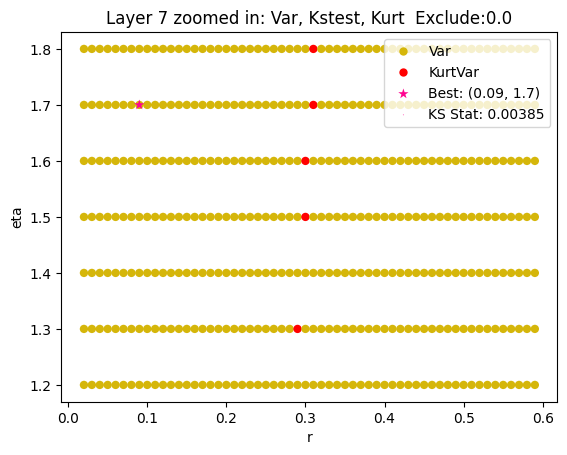

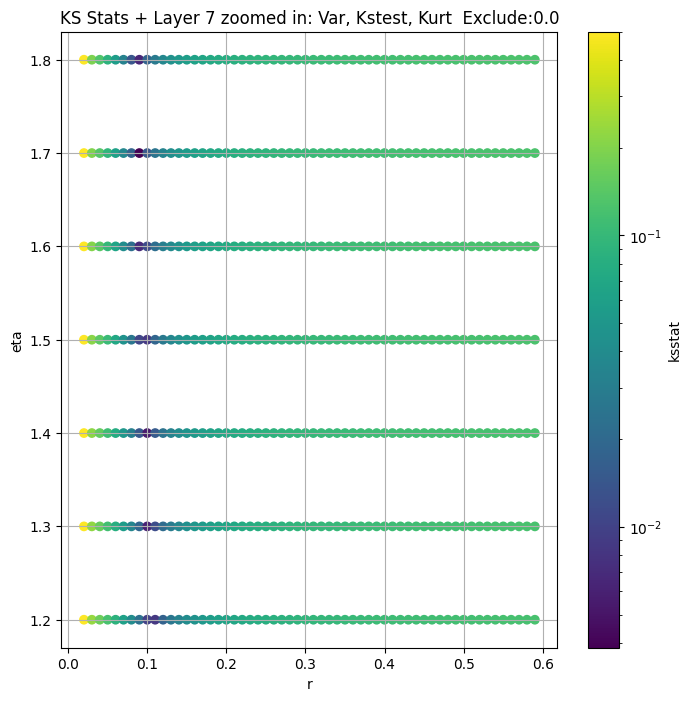

Layer 8


100%|██████████| 580/580 [00:01<00:00, 303.05it/s]


Finding Minimum after computing 580 CDFs
layer 8, 25.0 + 100 = 125, ksstat: 0.004144590166341278, var: 980.6493530273438


100%|██████████| 580/580 [00:01<00:00, 303.03it/s]


Finding Minimum after computing 580 CDFs
layer 8, 25.0 + 75 = 100, ksstat: 0.0038332602755100087, var: 1002.902587890625


100%|██████████| 580/580 [00:01<00:00, 302.36it/s]


Finding Minimum after computing 580 CDFs
layer 8, 25.0 + 50 = 75, ksstat: 0.003585170220493471, var: 1026.8055419921875


100%|██████████| 580/580 [00:01<00:00, 296.30it/s]


Finding Minimum after computing 580 CDFs
layer 8, 25.0 + 25 = 50, ksstat: 0.003367900157483783, var: 1052.7261962890625


100%|██████████| 580/580 [00:01<00:00, 303.69it/s]


Finding Minimum after computing 580 CDFs
layer 8, 25.0 + 0 = 25, ksstat: 0.0033650636516976418, var: 1081.320068359375


100%|██████████| 580/580 [00:01<00:00, 302.93it/s]


Finding Minimum after computing 580 CDFs
layer 8, 25.0 + -25 = 0, ksstat: 0.004066783884530328, var: 1116.0948486328125
Number of samples: 100000, Without approximation : 42110360.0


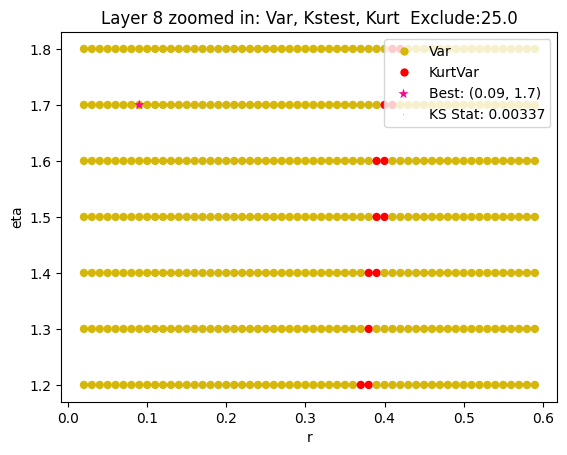

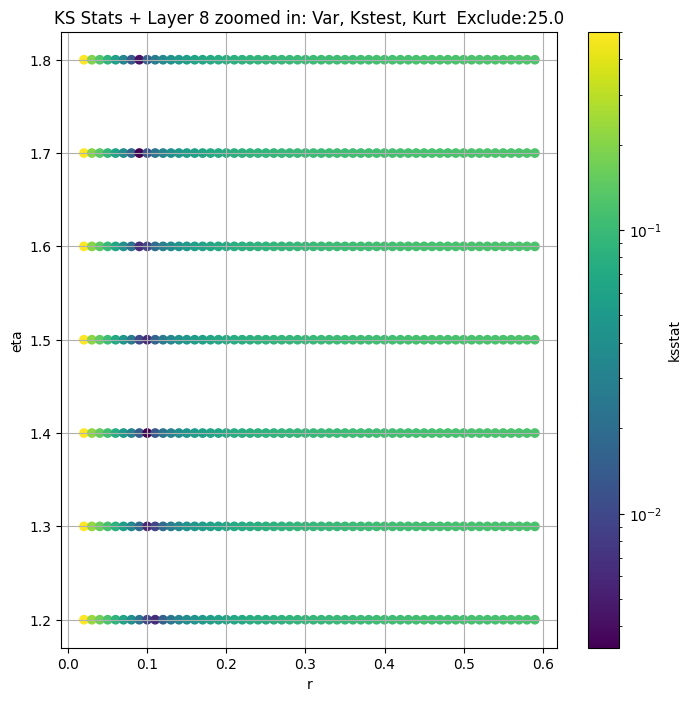

Layer 9


100%|██████████| 580/580 [00:01<00:00, 303.03it/s]


Finding Minimum after computing 580 CDFs
layer 9, 100.0 + 100 = 200, ksstat: 0.005273031266089245, var: 81.01996612548828


100%|██████████| 580/580 [00:01<00:00, 302.58it/s]


Finding Minimum after computing 580 CDFs
layer 9, 100.0 + 75 = 175, ksstat: 0.004890033926413042, var: 83.00508117675781


100%|██████████| 580/580 [00:01<00:00, 303.95it/s]


Finding Minimum after computing 580 CDFs
layer 9, 100.0 + 50 = 150, ksstat: 0.004486165101295087, var: 85.18109130859375


100%|██████████| 580/580 [00:01<00:00, 304.06it/s]


Finding Minimum after computing 580 CDFs
layer 9, 100.0 + 25 = 125, ksstat: 0.004089306822688266, var: 87.58604431152344


100%|██████████| 580/580 [00:01<00:00, 296.67it/s]


Finding Minimum after computing 580 CDFs
layer 9, 100.0 + 0 = 100, ksstat: 0.0035054378419678844, var: 90.26913452148438


100%|██████████| 580/580 [00:01<00:00, 302.67it/s]


Finding Minimum after computing 580 CDFs
layer 9, 100.0 + -25 = 75, ksstat: 0.003245899340507674, var: 93.29136657714844


100%|██████████| 580/580 [00:01<00:00, 303.56it/s]


Finding Minimum after computing 580 CDFs
layer 9, 100.0 + -50 = 50, ksstat: 0.0037384150440561426, var: 96.75117492675781


100%|██████████| 580/580 [00:01<00:00, 299.37it/s]


Finding Minimum after computing 580 CDFs
layer 9, 100.0 + -75 = 25, ksstat: 0.00453750489958038, var: 100.90052032470703


100%|██████████| 580/580 [00:01<00:00, 304.18it/s]


Finding Minimum after computing 580 CDFs
layer 9, 100.0 + -100 = 0, ksstat: 0.004818507977087105, var: 107.68609619140625
Number of samples: 100000, Without approximation : 170911996.0


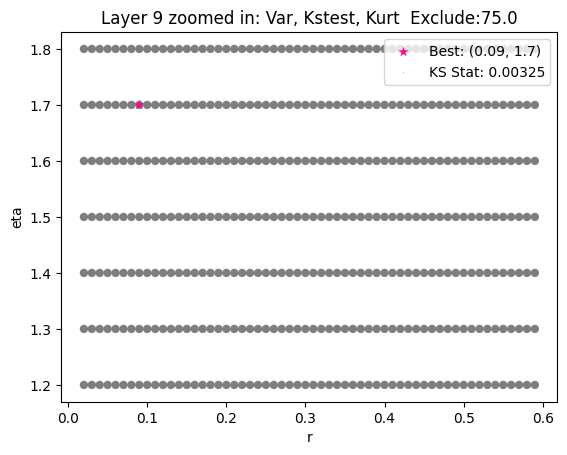

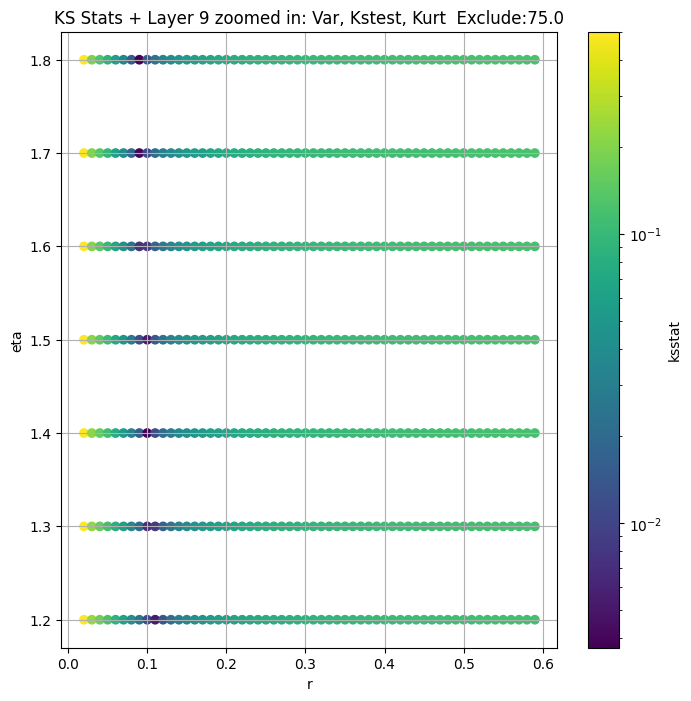

Cannot compute pval with ksstat : nan, n : 0.0


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff,n_pval_0.05
layer,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,170242.3400,158532.73000,182420.11000,0.515903,0.211426,0.856390,3396.0,0.005922,1.8,3.2,1.000000e+05,0.0,170242.340000,0.023255,0.005922,1.80,3.20,1.000000e+05,0.0,55069
4,211857.3600,203747.67000,220165.00000,0.256788,0.035012,0.512372,98808.0,0.006620,2.7,20.0,9.873809e+04,25.0,209810.100000,0.004319,0.006620,2.70,20.00,9.873809e+04,25.0,41683
5,72605.1400,68413.51000,76957.79000,3.195013,2.597310,3.898776,524004.0,0.004531,0.6,-0.2,1.608277e+04,0.0,72605.140625,0.001876,0.004015,0.70,-0.36,3.087279e+04,0.0,110530
6,29841.0370,27415.11100,32359.33800,8.380878,7.359658,9.473640,2418270.0,0.002861,0.1,2.3,1.588120e-12,0.0,29841.037109,0.000873,0.002700,0.11,1.90,2.844525e-10,0.0,255049
7,8457.4630,7687.83840,9267.63400,11.092089,9.864655,12.411221,10234344.0,0.004109,0.1,1.4,4.807675e-12,25.0,8457.462891,0.000425,0.003846,0.09,1.70,1.170631e-14,0.0,119932
8,1116.0948,1005.35650,1233.48550,13.691368,11.792415,16.311457,42110360.0,0.003394,0.1,1.4,6.303396e-13,25.0,1081.320068,0.000209,0.003365,0.09,1.70,1.496698e-15,25.0,164493
9,107.6861,94.23181,123.26981,24.950508,16.698538,47.740410,170911996.0,0.003709,0.1,1.4,5.262106e-14,100.0,93.291367,0.000104,0.003246,0.09,1.70,1.291282e-16,75.0,166906


In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

> In quadgk/vadapt (line 278)
In quadgk (line 204)
In compute_cdf_using_gengamma_with_scale (line 10)


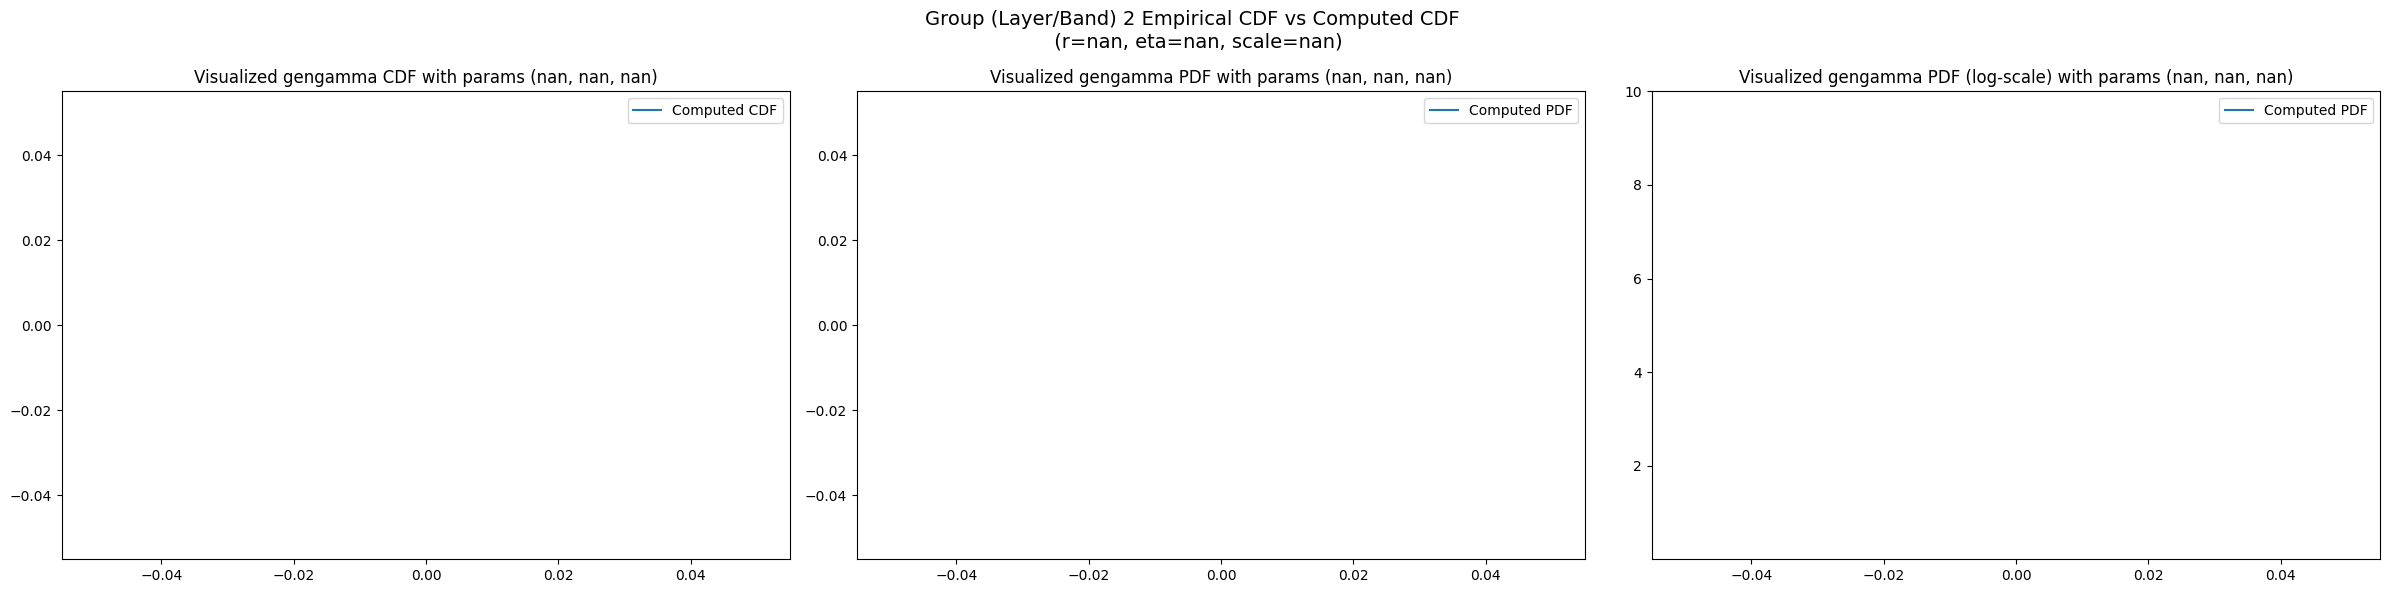

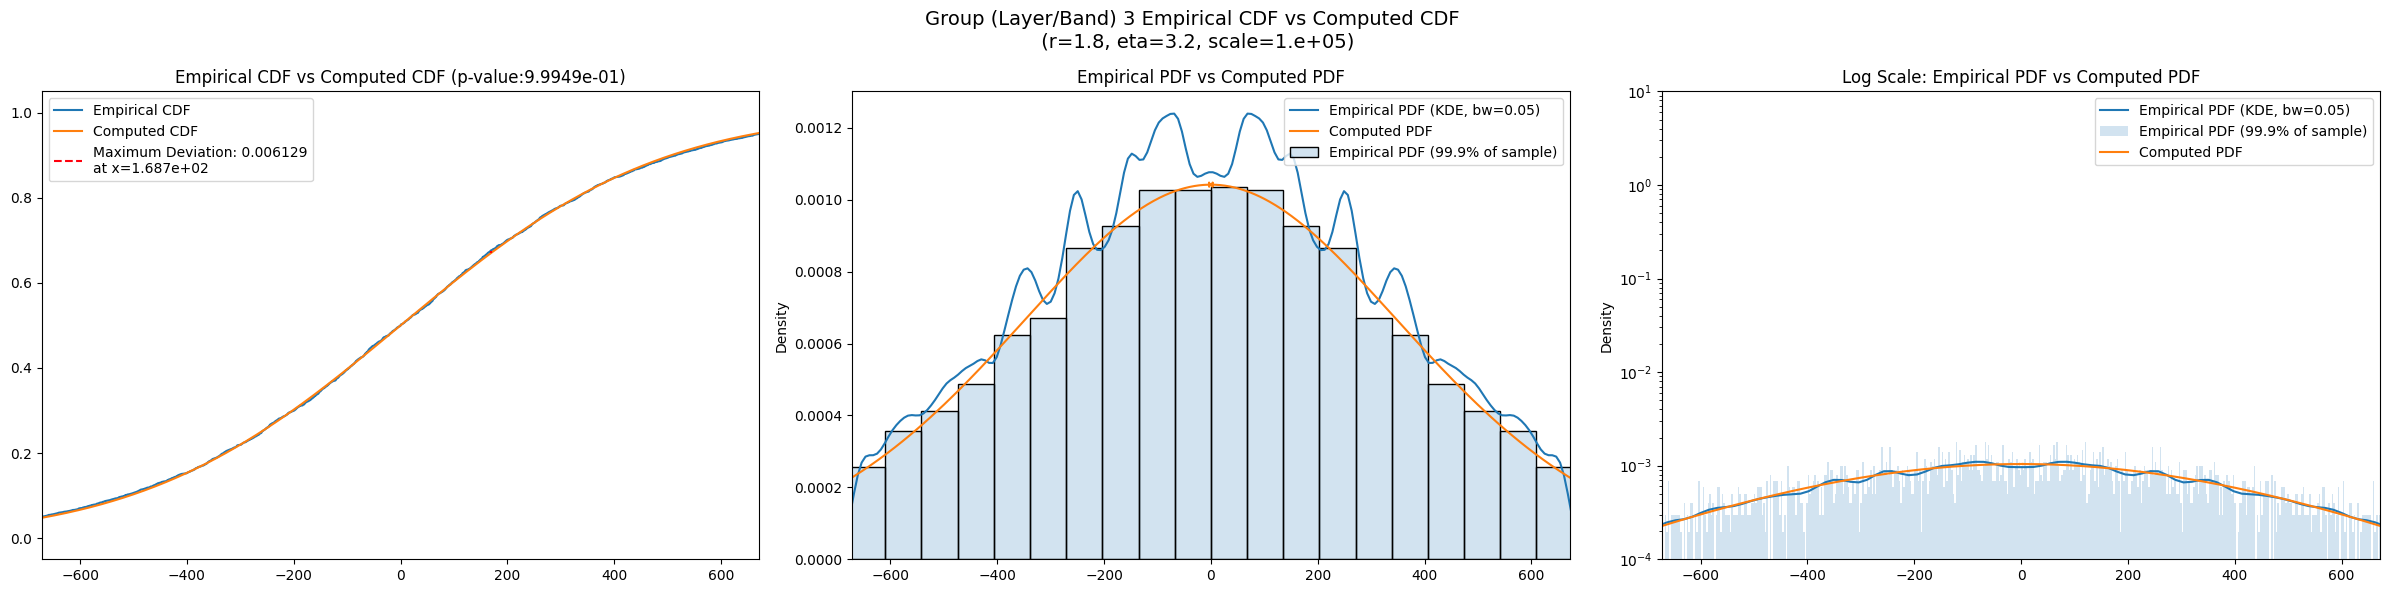

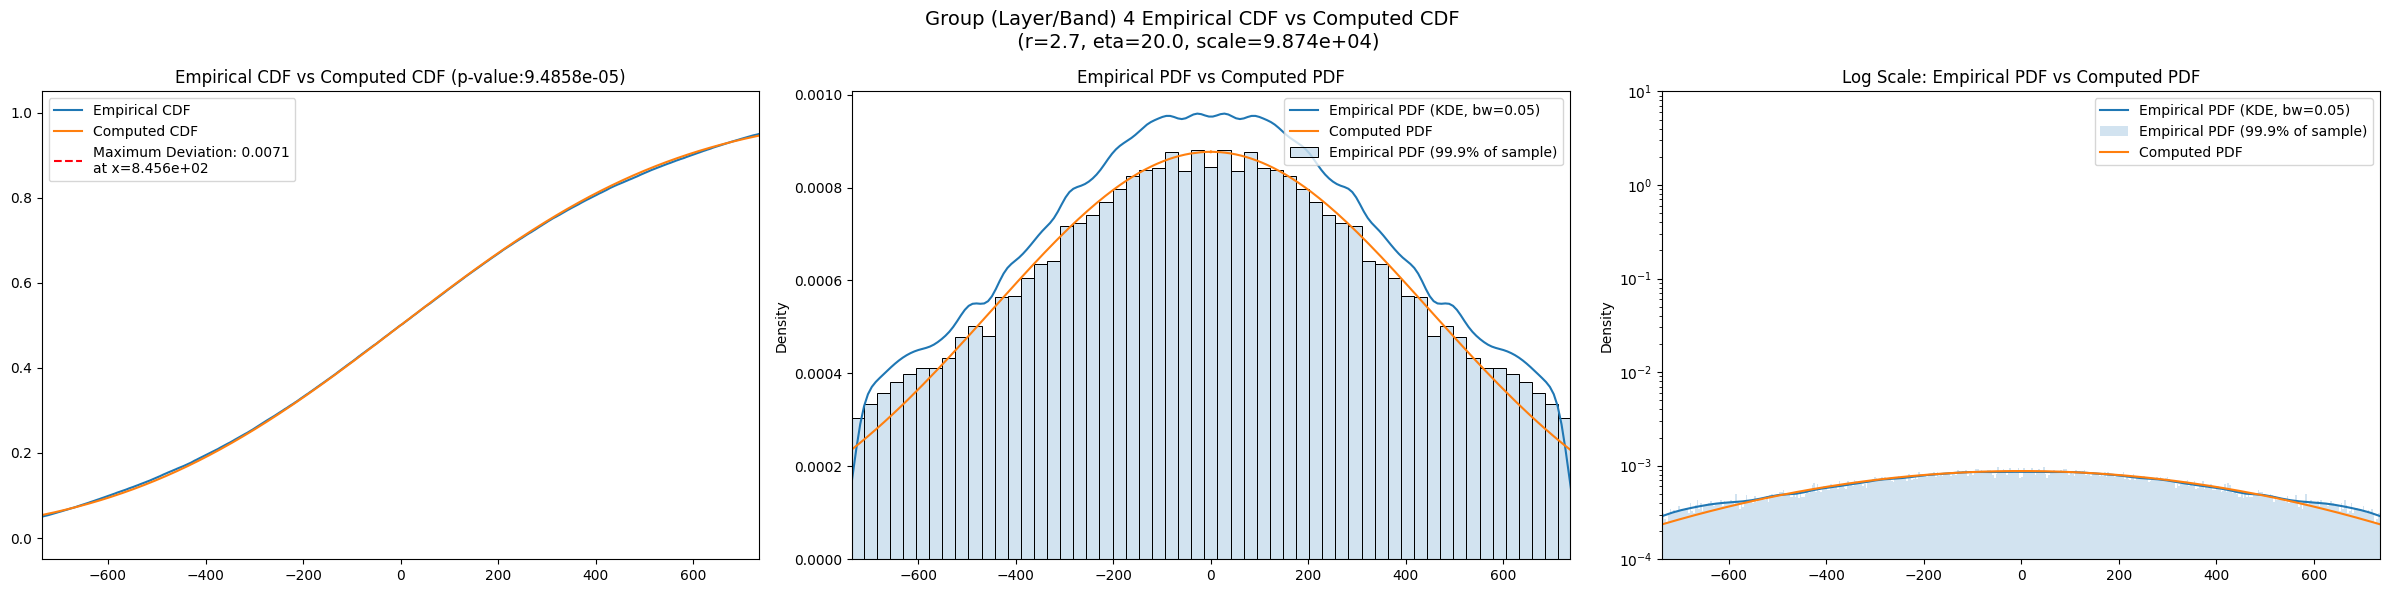

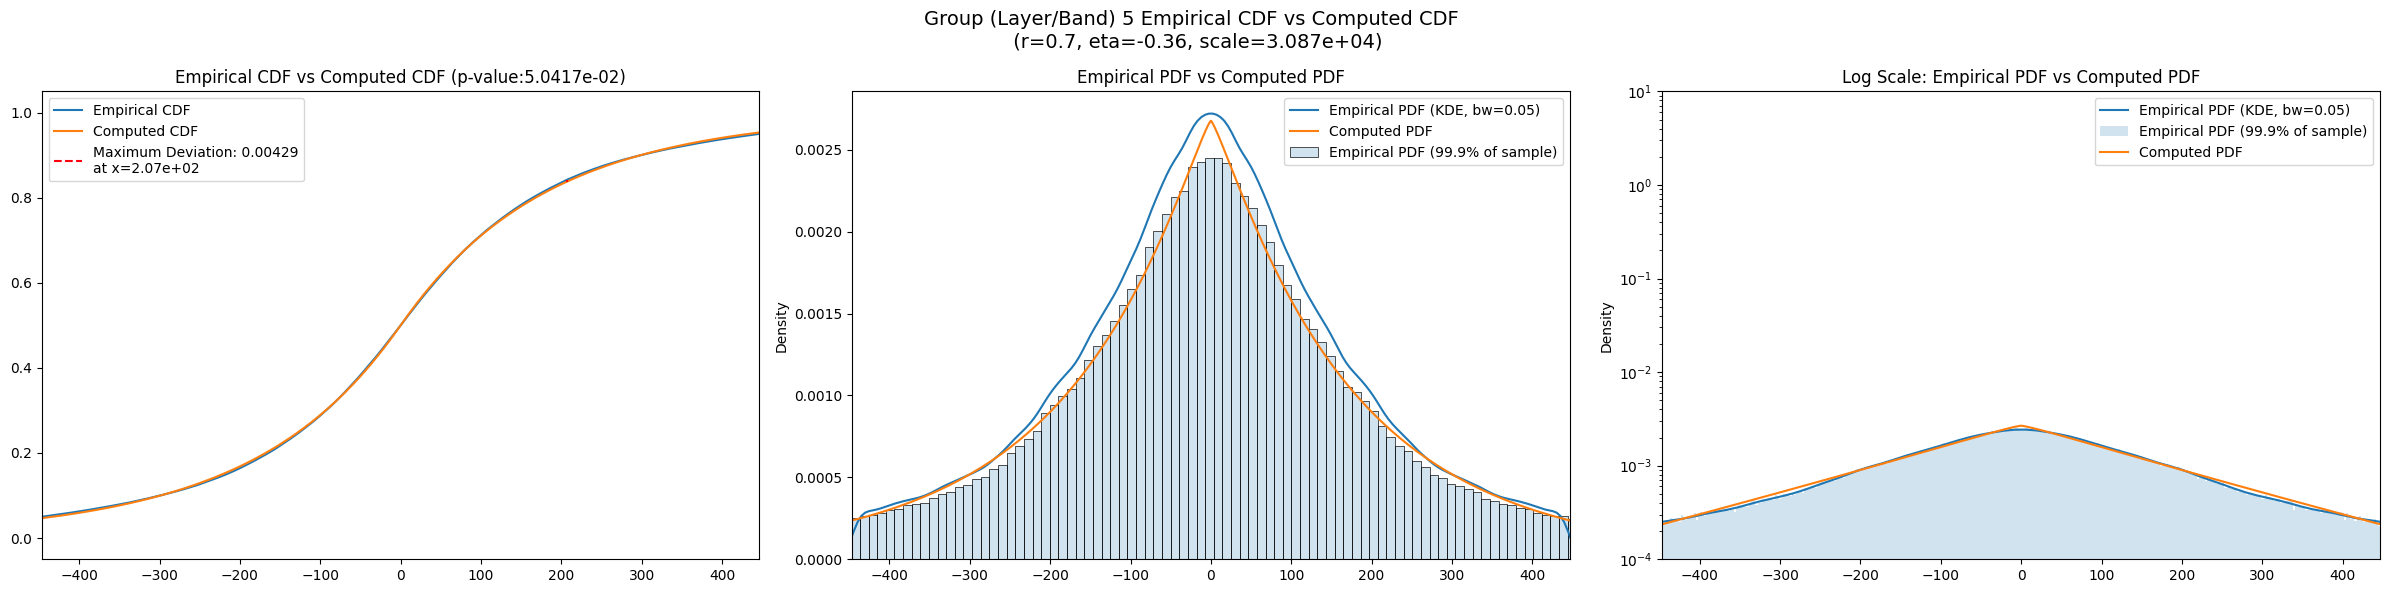

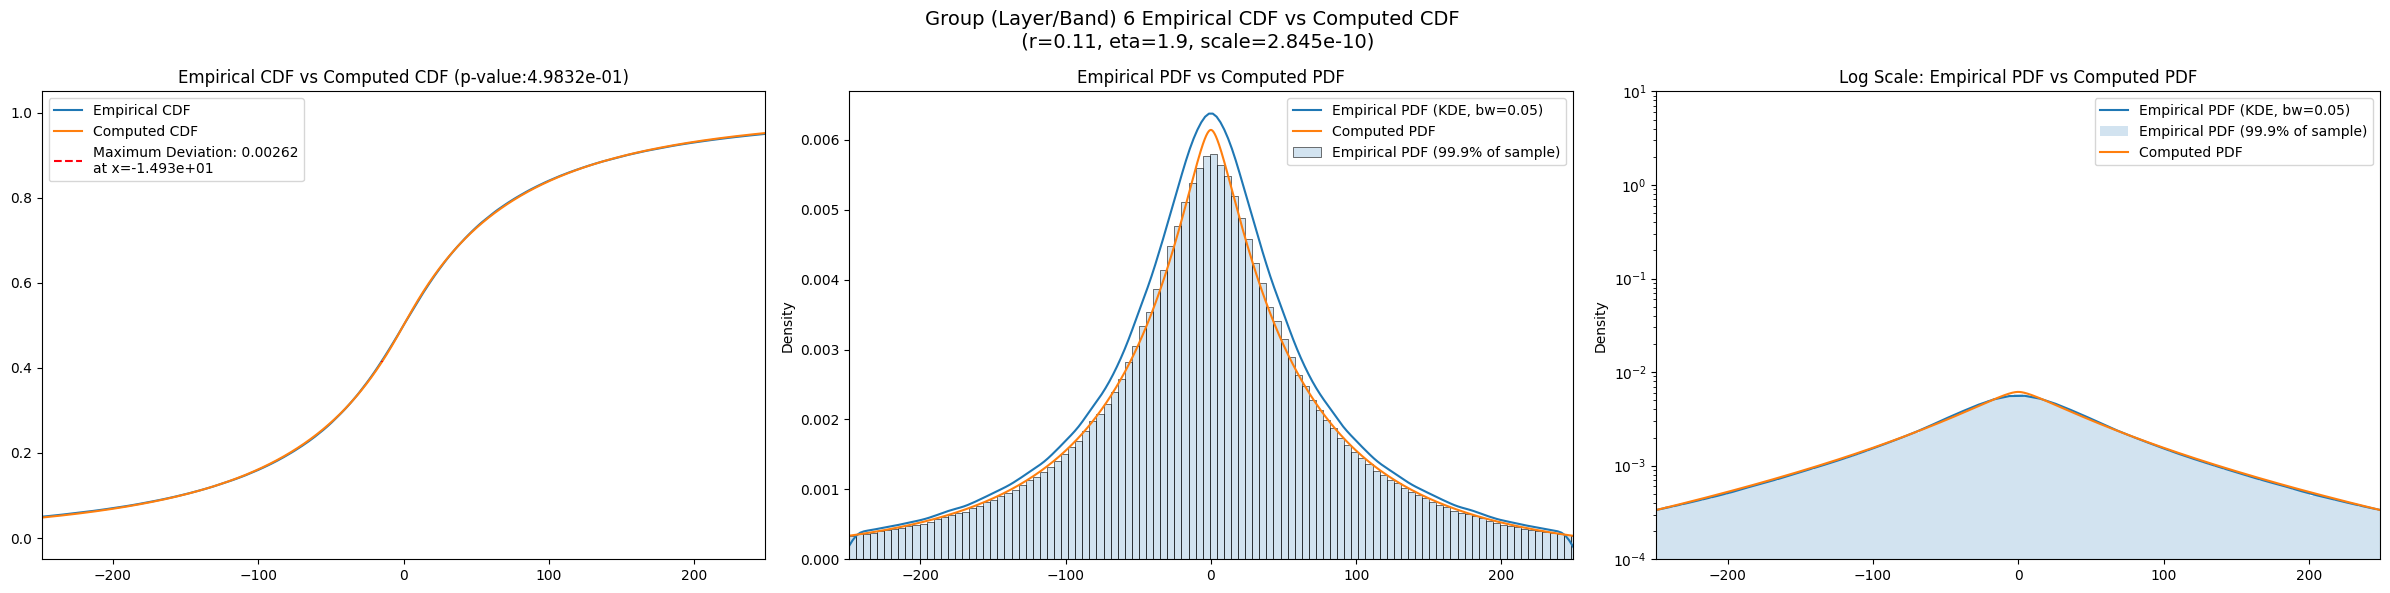

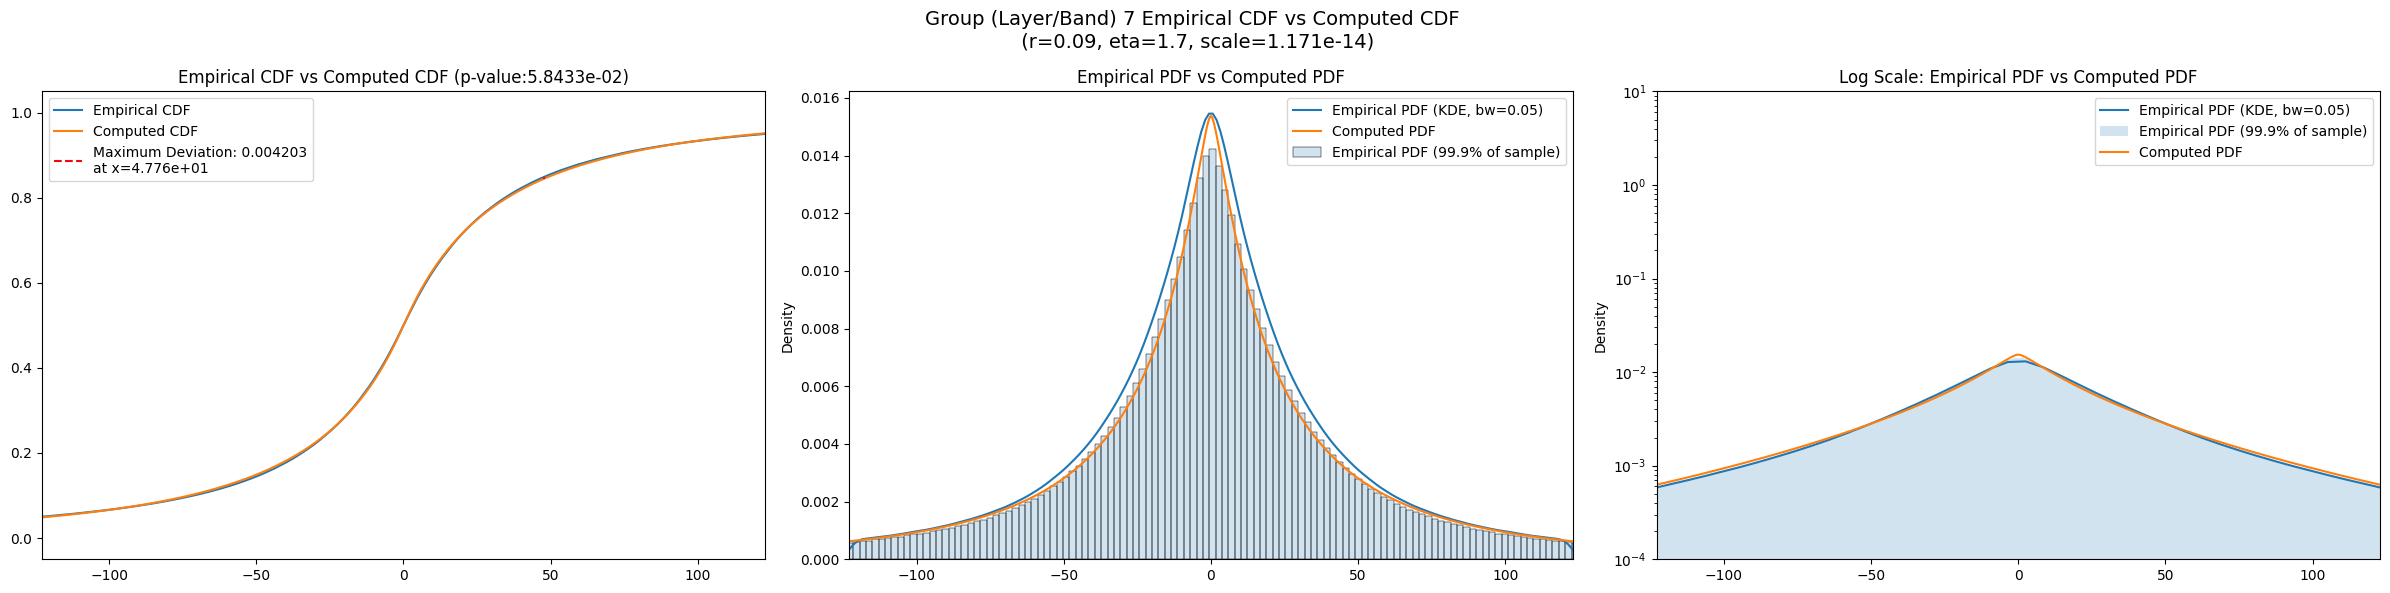

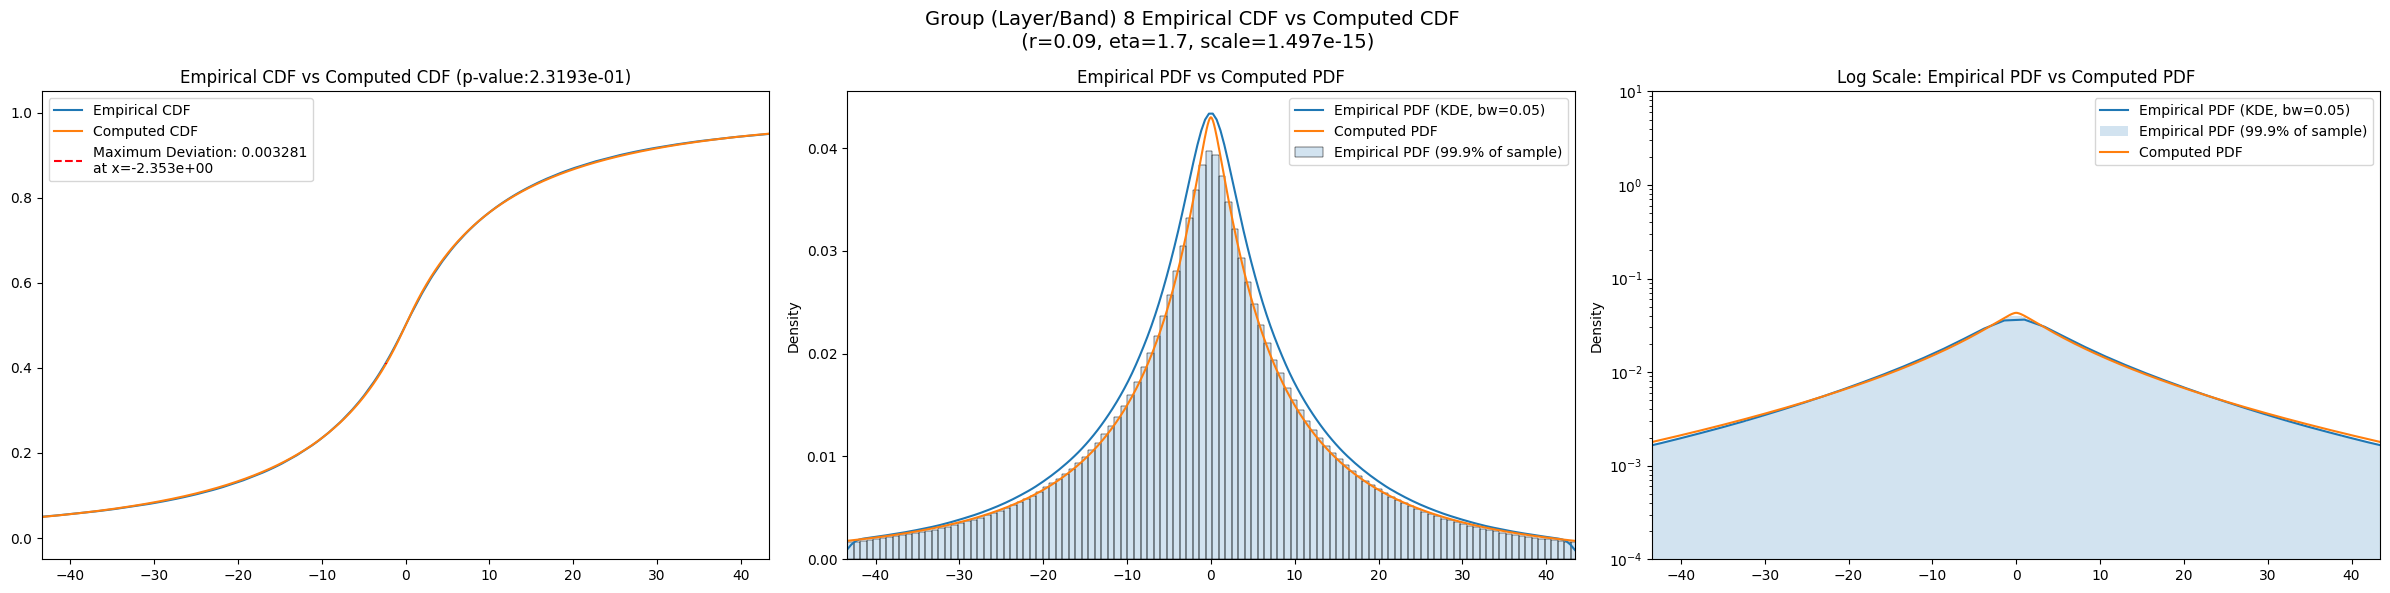

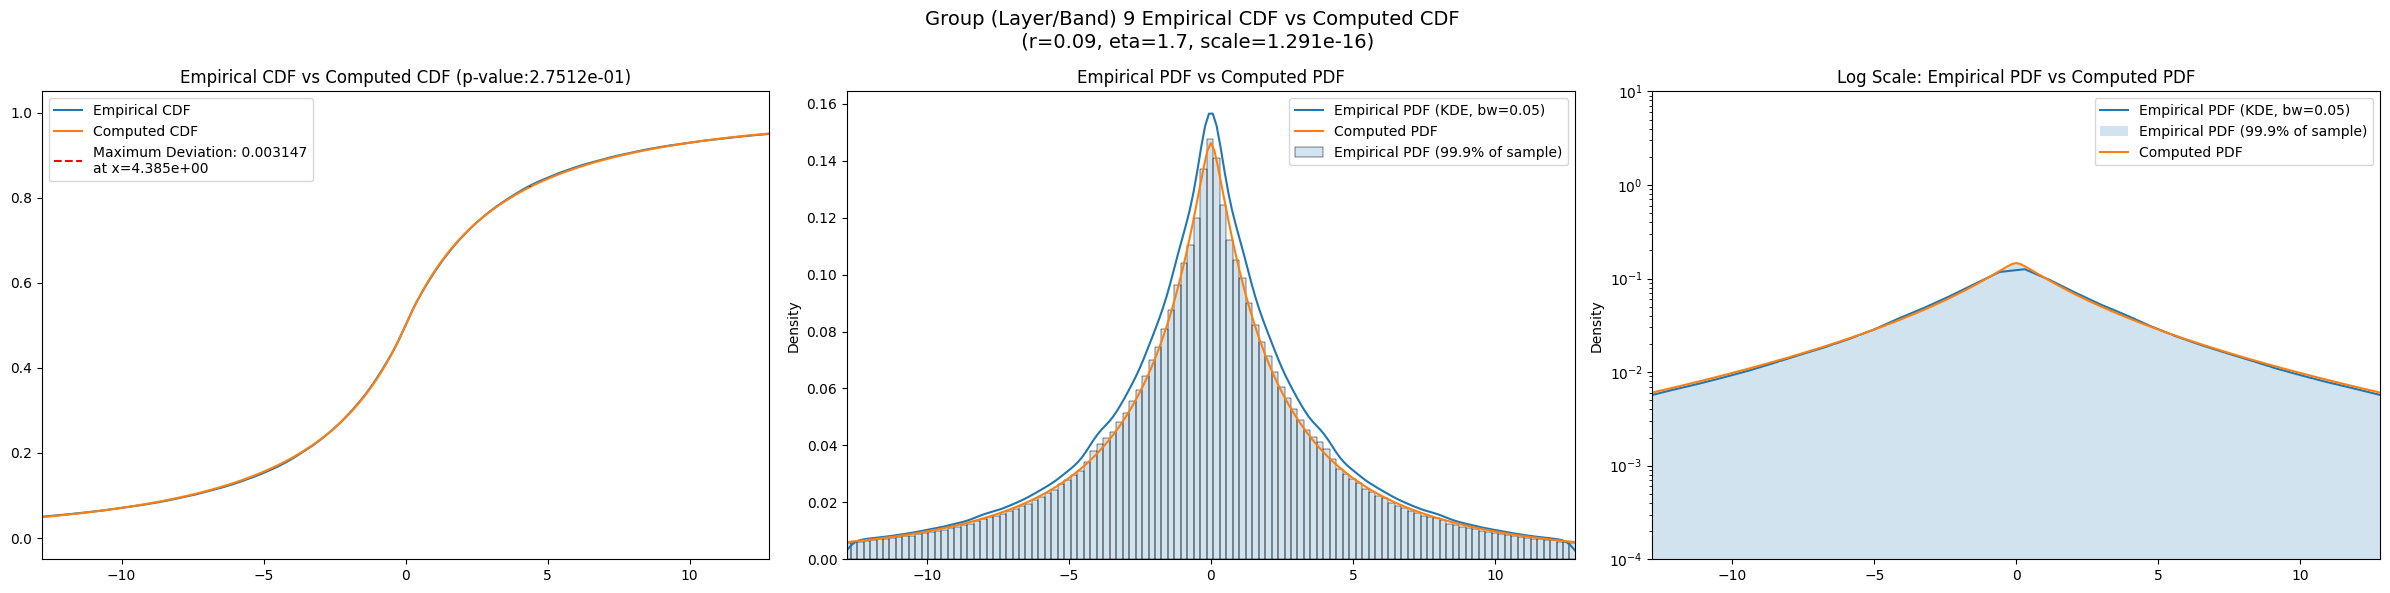

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,170242.3400,158532.73000,182420.11000,0.515903,0.211426,0.856390,3396.0,0.005922,1.8,3.2,...,392.01900,0.008947,0.946333,347.65600,0.023046,5.340200e-02,284.38600,0.027423,1.187420e-02,9.997300e-01
4,211857.3600,203747.67000,220165.00000,0.256788,0.035012,0.512372,98808.0,0.006620,2.7,20.0,...,456.79500,0.006119,0.001218,391.98600,0.031869,1.273190e-87,322.13800,0.034592,3.668920e-103,3.454072e-04
5,72605.1400,68413.51000,76957.79000,3.195013,2.597310,3.898776,524004.0,0.004531,0.6,-0.2,...,214.31100,0.032434,0.000000,185.29600,0.005682,4.047900e-15,149.54300,0.008863,3.488880e-36,9.200301e-08
6,29841.0370,27415.11100,32359.33800,8.380878,7.359658,9.473640,2418270.0,0.002861,0.1,2.3,...,103.16600,0.044973,0.000000,90.87430,0.018359,0.000000e+00,72.79290,0.016072,0.000000e+00,9.842571e-16
7,8457.4630,7687.83840,9267.63400,11.092089,9.864655,12.411221,10234344.0,0.004109,0.1,1.4,...,46.80700,0.050492,0.000000,41.57750,0.024662,0.000000e+00,32.64520,0.021251,0.000000e+00,6.492970e-132
8,1116.0948,1005.35650,1233.48550,13.691368,11.792415,16.311457,42110360.0,0.003394,0.1,1.4,...,16.68270,0.049836,0.000000,14.83420,0.023970,0.000000e+00,11.62510,0.021208,0.000000e+00,0.000000e+00
9,107.6861,94.23181,123.26981,24.950508,16.698538,47.740410,170911996.0,0.003709,0.1,1.4,...,4.90653,0.050382,0.000000,4.35475,0.024286,0.000000e+00,3.40785,0.021950,0.000000e+00,0.000000e+00


## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_best,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t
layer,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN
3,0.005922,0.023255,0.005922,0.008947,0.023046,0.027423
4,0.006620,0.004319,0.006620,0.006119,0.031869,0.034592
5,0.004531,0.001876,0.004015,0.032434,0.005682,0.008863
6,0.002861,0.000873,0.002700,0.044973,0.018359,0.016072
7,0.004109,0.000425,0.003846,0.050492,0.024662,0.021251
8,0.003394,0.000209,0.003365,0.049836,0.023970,0.021208
9,0.003709,0.000104,0.003246,0.050382,0.024286,0.021950


In [20]:
master_df.filter(regex="best.*")

,best_augmented_var,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff
layer,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN
3,170242.340000,0.005922,1.80,3.20,1.000000e+05,0.0
4,209810.100000,0.006620,2.70,20.00,9.873809e+04,25.0
5,72605.140625,0.004015,0.70,-0.36,3.087279e+04,0.0
6,29841.037109,0.002700,0.11,1.90,2.844525e-10,0.0
7,8457.462891,0.003846,0.09,1.70,1.170631e-14,0.0
8,1081.320068,0.003365,0.09,1.70,1.496698e-15,25.0
9,93.291367,0.003246,0.09,1.70,1.291282e-16,75.0


In [21]:
eng.quit()